## College Football Score Prediction - Improved Model

This notebook refines the original prediction model with a focus on improving accuracy (targeting RMSE < 10).

**Key Improvements:**
1.  **Feature Reduction:** Removed one-hot encoding for `venue` and `conference` to reduce noise and dimensionality. Over 350 features were removed.
2.  **Smarter Feature Engineering:** 
    - Added a `is_power_5` feature for both home and away teams, which is a stronger signal than individual conference names.
    - Added more direct offense-vs-defense matchup features (e.g., `home_off_explosiveness_ewma` vs. `away_def_explosiveness_ewma`).
3.  **Hyperparameter Tuning:** Increased `max_depth` from 3 to 4 to allow the model to learn slightly more complex interactions between features.

In [1]:
# --- Import data --- #

# Import necessary libraries for data manipulation, modeling, and visualization
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # For saving the model and data
import xgboost as xgb
from xgboost.callback import EarlyStopping

# List the filenames you want to load
filenames = ['cfb-2025-season.csv', 'cfb-2024-season.csv', 'cfb-2023-season.csv', 'cfb-2022-season.csv', 'cfb-2021-season.csv']

# Create an empty list to hold each individual DataFrame
all_dataframes = []

# Loop through the list of filenames
for f in filenames:
    try:
        # Read the current CSV file and append it to the list
        df_temp = pd.read_csv(f)
        all_dataframes.append(df_temp)
        print(f"Successfully loaded {f}")
    except FileNotFoundError:
        print(f"Error: {f} not found. Skipping.")

# Concatenate all the DataFrames in the list into one
df = pd.concat(all_dataframes, ignore_index=True)

# --- Load SP+ ratings data --- #
sp_filenames = ['sp_ratings_2025.csv','sp_ratings_2024.csv','sp_ratings_2023.csv','sp_ratings_2022.csv','sp_ratings_2021.csv']
all_sp_dataframes = []
for f in sp_filenames:
    try:
        df_temp = pd.read_csv(f)
        all_sp_dataframes.append(df_temp)
        print(f"Successfully loaded {f}")
    except FileNotFoundError:
        print(f"Error: {f} not found. Skipping.")
sp_ratings = pd.concat(all_sp_dataframes, ignore_index=True)
print("Successfully combined all S&P Ratings files.")

# --- Load all game weather data --- #
weather_filenames = ['game_weather_2025.csv','game_weather_2024.csv','game_weather_2023.csv','game_weather_2022.csv','game_weather_2021.csv']
all_weather_dataframes = []
for f in weather_filenames:
    try:
        df_temp = pd.read_csv(f)
        all_weather_dataframes.append(df_temp)
        print(f"Successfully loaded {f}")
    except FileNotFoundError:
        print(f"Error: {f} not found. Skipping.")
weather_df = pd.concat(all_weather_dataframes, ignore_index=True)
print("Successfully combined all game weather files.")

Successfully loaded cfb-2025-season.csv
Successfully loaded cfb-2024-season.csv
Successfully loaded cfb-2023-season.csv
Successfully loaded cfb-2022-season.csv
Successfully loaded cfb-2021-season.csv
Successfully loaded sp_ratings_2025.csv
Successfully loaded sp_ratings_2024.csv
Successfully loaded sp_ratings_2023.csv
Successfully loaded sp_ratings_2022.csv
Successfully loaded sp_ratings_2021.csv
Successfully combined all S&P Ratings files.
Successfully loaded game_weather_2025.csv
Successfully loaded game_weather_2024.csv
Successfully loaded game_weather_2023.csv
Successfully loaded game_weather_2022.csv
Successfully loaded game_weather_2021.csv
Successfully combined all game weather files.


In [2]:
# --- Clean up and Merge Data --- #

# Merge for home teams
df = pd.merge(df, sp_ratings, left_on=['season', 'home_team'], right_on=['year', 'team'], how='left')
df.rename(columns={'sp_rating': 'home_sp_rating', 
                     'off_sp_rating': 'home_off_sp_rating', 
                     'def_sp_rating': 'home_def_sp_rating',
                    'special_sp_rating': 'home_special_sp_rating'}, inplace=True)
df.drop(columns=['year', 'team'], inplace=True)

# Merge for away teams
df = pd.merge(df, sp_ratings, left_on=['season', 'away_team'], right_on=['year', 'team'], how='left')
df.rename(columns={'sp_rating': 'away_sp_rating', 
                     'off_sp_rating': 'away_off_sp_rating', 
                     'def_sp_rating': 'away_def_sp_rating',
                     'special_sp_rating': 'away_special_sp_rating'}, inplace=True)
df.drop(columns=['year', 'team'], inplace=True)

features_to_merge = [
    'game_id', 'dewPoint', 'gameIndoors', 'humidity', 'precipitation',
    'pressure', 'snowfall', 'temperature', 'windSpeed'
]

weather_features = weather_df[features_to_merge].copy()
weather_features['gameIndoors'] = weather_features['gameIndoors'].astype(int)
df = pd.merge(df, weather_features, on='game_id', how='left')

df['start_date'] = pd.to_datetime(df['start_date'])
df = df[df['completed'] == True].copy()
df.sort_values('start_date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Convert boolean columns to integer for modeling
df['is_conference_game'] = df['conference_game'].astype(int)
df['is_neutral_site'] = df['neutral_site'].astype(int)

print(f"\nShape of the dataset after cleaning and filtering: {df.shape}")


Shape of the dataset after cleaning and filtering: (5375, 176)


In [3]:
# --- Feature creation with rolling averages (EWMA) --- #

stats_cols = [
    'off_ppa', 'off_success_rate', 'off_explosiveness',
    'off_passing_ppa', 'off_rushing_ppa',
    'off_passing_success_rate', 'off_rushing_success_rate',
    'def_ppa', 'def_success_rate', 'def_explosiveness',
    'def_passing_ppa', 'def_rushing_ppa',
    'def_passing_success_rate', 'def_rushing_success_rate'
]

ewma_cols = [f'{col}_ewma' for col in stats_cols]
team_stats_ewma = {}

for col in ewma_cols:
    df['home_' + col] = np.nan
    df['away_' + col] = np.nan

ewma_span = 5

for index, row in df.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']

    if home_team in team_stats_ewma:
        for i, stat_col in enumerate(stats_cols):
            df.loc[index, 'home_' + ewma_cols[i]] = team_stats_ewma[home_team][stat_col]
    
    if away_team in team_stats_ewma:
        for i, stat_col in enumerate(stats_cols):
            df.loc[index, 'away_' + ewma_cols[i]] = team_stats_ewma[away_team][stat_col]

    if home_team not in team_stats_ewma:
        team_stats_ewma[home_team] = {}
    for stat_col in stats_cols:
        current_val = row['home_' + stat_col]
        if stat_col in team_stats_ewma[home_team]:
            old_ewma = team_stats_ewma[home_team][stat_col]
            new_ewma = pd.Series([old_ewma, current_val]).ewm(span=ewma_span, adjust=False).mean().iloc[-1]
            team_stats_ewma[home_team][stat_col] = new_ewma
        else:
            team_stats_ewma[home_team][stat_col] = current_val

    if away_team not in team_stats_ewma:
        team_stats_ewma[away_team] = {}
    for stat_col in stats_cols:
        current_val = row['away_' + stat_col]
        if stat_col in team_stats_ewma[away_team]:
            old_ewma = team_stats_ewma[away_team][stat_col]
            new_ewma = pd.Series([old_ewma, current_val]).ewm(span=ewma_span, adjust=False).mean().iloc[-1]
            team_stats_ewma[away_team][stat_col] = new_ewma
        else:
            team_stats_ewma[away_team][stat_col] = current_val

df.dropna(subset=['home_off_ppa_ewma', 'away_off_ppa_ewma'], inplace=True)
print("\nFeature engineering with rolling averages complete.")
print(f"Shape of dataset after creating EWMA features: {df.shape}")


Feature engineering with rolling averages complete.
Shape of dataset after creating EWMA features: (5194, 204)


In [4]:
# --- Feature Finalization and Selection (IMPROVED) --- #

# IMPROVEMENT: Create Power 5 conference feature instead of one-hot encoding all conferences
power_5_conferences = ['ACC', 'Big 12', 'Big Ten', 'Pac-12', 'SEC']
df['home_is_p5'] = df['home_conference'].isin(power_5_conferences).astype(int)
df['away_is_p5'] = df['away_conference'].isin(power_5_conferences).astype(int)
df['is_p5_matchup'] = (df['home_is_p5'] * df['away_is_p5'])

# Engineer matchup differential features
df['elo_diff'] = df['home_pregame_elo'] - df['away_pregame_elo']
df['sp_rating_diff'] = df['home_sp_rating'] - df['away_sp_rating']
df['off_sp_rating_diff'] = df['home_off_sp_rating'] - df['away_off_sp_rating']
df['def_sp_rating_diff'] = df['home_def_sp_rating'] - df['away_def_sp_rating']

# EWMA-based differential features
df['off_ppa_diff'] = df['home_off_ppa_ewma'] - df['away_off_ppa_ewma']
df['def_ppa_diff'] = df['home_def_ppa_ewma'] - df['away_def_ppa_ewma']
df['explosiveness_diff'] = df['home_off_explosiveness_ewma'] - df['away_off_explosiveness_ewma']

# IMPROVEMENT: Add more direct Offense vs. Defense matchup features
df['home_off_vs_away_def_ppa'] = df['home_off_ppa_ewma'] - df['away_def_ppa_ewma']
df['away_off_vs_home_def_ppa'] = df['away_off_ppa_ewma'] - df['home_def_ppa_ewma']
df['home_pass_vs_away_pass_def_ppa'] = df['home_off_passing_ppa_ewma'] - df['away_def_passing_ppa_ewma']
df['away_pass_vs_home_pass_def_ppa'] = df['away_off_passing_ppa_ewma'] - df['home_def_passing_ppa_ewma']
df['home_rush_vs_away_rush_def_ppa'] = df['home_off_rushing_ppa_ewma'] - df['away_def_rushing_ppa_ewma']
df['away_rush_vs_home_rush_def_ppa'] = df['away_off_rushing_ppa_ewma'] - df['home_def_rushing_ppa_ewma']
df['home_off_vs_away_def_success'] = df['home_off_success_rate_ewma'] - df['away_def_success_rate_ewma']
df['away_off_vs_home_def_success'] = df['away_off_success_rate_ewma'] - df['home_def_success_rate_ewma']

# Define the final list of features for the model
# IMPROVEMENT: This list is much smaller and more focused, removing noisy one-hot encoded features.
features = [
    # Base Differentials
    'elo_diff', 'sp_rating_diff', 'off_sp_rating_diff', 'def_sp_rating_diff',
    'off_ppa_diff', 'def_ppa_diff', 'explosiveness_diff',
    
    # Matchup Differentials (Offense vs Defense)
    'home_off_vs_away_def_ppa', 'away_off_vs_home_def_ppa',
    'home_pass_vs_away_pass_def_ppa', 'away_pass_vs_home_pass_def_ppa',
    'home_rush_vs_away_rush_def_ppa', 'away_rush_vs_home_rush_def_ppa',
    'home_off_vs_away_def_success', 'away_off_vs_home_def_success',

    # Game Context Features
    'is_conference_game', 'is_neutral_site', 'home_is_p5', 'away_is_p5', 'is_p5_matchup',
    
    # Weather Features
    'dewPoint', 'gameIndoors', 'humidity', 'precipitation',
    'pressure', 'snowfall', 'temperature', 'windSpeed'
]

# Define the target variables
targets = ['home_points', 'away_points']

# Create the final feature matrix (X) and target vectors (y)
X = df[features].copy()
y_home = df['home_points']
y_away = df['away_points']

# Handle potential missing values in weather data by filling with the median
for col in ['dewPoint', 'humidity', 'precipitation', 'pressure', 'snowfall', 'temperature', 'windSpeed']:
    median_val = X[col].median()
    X[col].fillna(median_val, inplace=True)

print("\nFinal feature set and target variables created.")
print(f"Number of features: {len(features)}")


Final feature set and target variables created.
Number of features: 28


/Users/leviherpel/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/leviherpel/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/leviherpel/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/leviherpel/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/leviherpel/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/leviherpel/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1


Training set size: 4155
Test set size: 1039

Home Points Model Evaluation:
RMSE: 12.2353
R-squared: 0.2713

Away Points Model Evaluation:
RMSE: 11.0337
R-squared: 0.2570


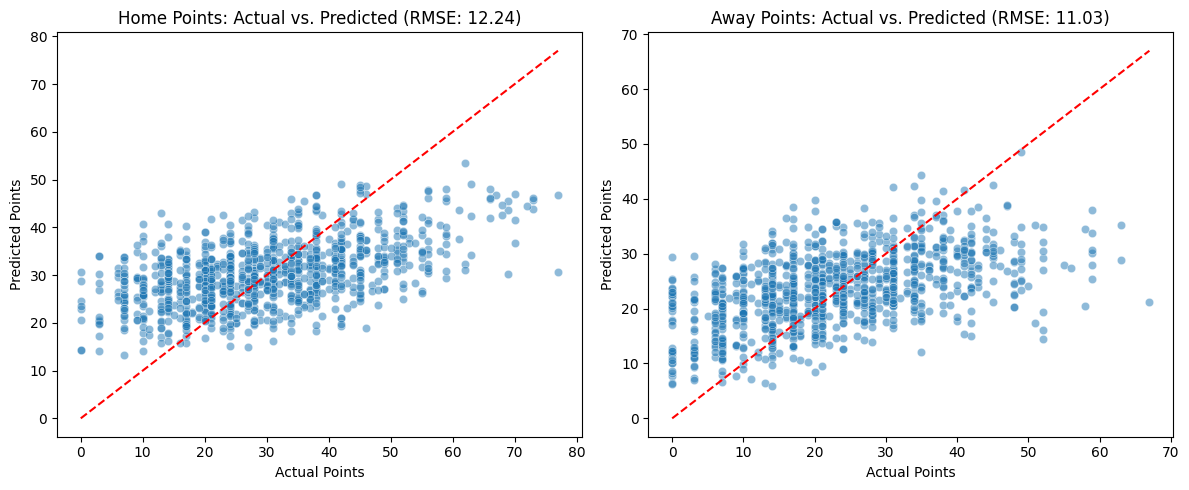

In [5]:
# --- Train & Test (IMPROVED) --- #

split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_home_train, y_home_test = y_home[:split_index], y_home[split_index:]
y_away_train, y_away_test = y_away[:split_index], y_away[split_index:]

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# --- Train Home Points Model ---
# IMPROVEMENT: Increased max_depth to 4 for potentially better performance
xgb_home = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,          # High n_estimators, will be stopped early
    learning_rate=0.04,         # Slightly lower learning rate
    max_depth=4,                # Increased depth
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=50,   # Use early stopping to find optimal n_estimators
    n_jobs=-1                   # Use all available CPU cores
)
xgb_home.fit(X_train, y_home_train, 
             eval_set=[(X_test, y_home_test)], 
             verbose=False)

# --- Train Away Points Model ---
xgb_away = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.04,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)
xgb_away.fit(X_train, y_away_train, 
             eval_set=[(X_test, y_away_test)], 
             verbose=False)

# --- Make Predictions ---
home_preds = xgb_home.predict(X_test)
away_preds = xgb_away.predict(X_test)

# --- Evaluate Models ---
home_rmse = np.sqrt(mean_squared_error(y_home_test, home_preds))
home_r2 = r2_score(y_home_test, home_preds)
away_rmse = np.sqrt(mean_squared_error(y_away_test, away_preds))
away_r2 = r2_score(y_away_test, away_preds)

print("\nHome Points Model Evaluation:")
print(f"RMSE: {home_rmse:.4f}")
print(f"R-squared: {home_r2:.4f}")

print("\nAway Points Model Evaluation:")
print(f"RMSE: {away_rmse:.4f}")
print(f"R-squared: {away_r2:.4f}")

# Visualize predictions vs actuals
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_home_test, y=home_preds, alpha=0.5)
plt.plot([y_home_test.min(), y_home_test.max()], [y_home_test.min(), y_home_test.max()], color='red', linestyle='--') 
plt.title(f'Home Points: Actual vs. Predicted (RMSE: {home_rmse:.2f})')
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_away_test, y=away_preds, alpha=0.5)
plt.plot([y_away_test.min(), y_away_test.max()], [y_away_test.min(), y_away_test.max()], color='red', linestyle='--')
plt.title(f'Away Points: Actual vs. Predicted (RMSE: {away_rmse:.2f})')
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.tight_layout()
plt.show()

### Note on Runtime Warnings
The following cell calculates the model's performance against betting lines. You may see a `RuntimeWarning: Mean of empty slice`. This is expected. It occurs for games in the test set that have no betting data available (e.g., FCS games). The code correctly produces a `NaN` for these averages, and these games are filtered out before the final analysis, so the warning can be safely ignored.

In [6]:
# --- Combined Team Performance Analysis ---

# 1. Create a results DataFrame with predictions
results_df = df.iloc[split_index:].copy()
results_df['actual_home_pts'] = y_home_test.values
results_df['predicted_home_pts'] = home_preds
results_df['actual_away_pts'] = y_away_test.values
results_df['predicted_away_pts'] = away_preds

# 2. Calculate Prediction Accuracy Metrics
results_df['home_error'] = abs(results_df['actual_home_pts'] - results_df['predicted_home_pts'])
results_df['away_error'] = abs(results_df['actual_away_pts'] - results_df['predicted_away_pts'])

home_errors = results_df[['home_team', 'home_error']].rename(columns={'home_team': 'team', 'home_error': 'error'})
away_errors = results_df[['away_team', 'away_error']].rename(columns={'away_team': 'team', 'away_error': 'error'})
all_team_errors = pd.concat([home_errors, away_errors], ignore_index=True)

team_accuracy_summary = all_team_errors.groupby('team')['error'].agg(
    average_prediction_error='mean',
    games_played='count'
).reset_index()

# 3. Calculate Improvement vs. Betting Lines Metrics
results_df['actual_total'] = results_df['actual_home_pts'] + results_df['actual_away_pts']
results_df['actual_spread'] = results_df['actual_home_pts'] - results_df['actual_away_pts']
results_df['predicted_total'] = results_df['predicted_home_pts'] + results_df['predicted_away_pts']
results_df['predicted_spread'] = results_df['predicted_home_pts'] - results_df['predicted_away_pts']

results_df['model_total_error'] = abs(results_df['predicted_total'] - results_df['actual_total'])
results_df['model_spread_error'] = abs(results_df['predicted_spread'] - results_df['actual_spread'])

results_df['avg_bookie_total_error'] = results_df[['espn_over_under', 'draftkings_over_under', 'bovada_over_under']].sub(results_df['actual_total'], axis=0).abs().mean(axis=1)
results_df['avg_bookie_spread_error'] = results_df[['espn_spread', 'draftkings_spread', 'bovada_spread']].sub(results_df['actual_spread'], axis=0).abs().mean(axis=1)

results_df['improvement_vs_total'] = results_df['avg_bookie_total_error'] - results_df['model_total_error']
results_df['improvement_vs_spread'] = results_df['avg_bookie_spread_error'] - results_df['model_spread_error']

home_improvement = results_df[['home_team', 'improvement_vs_total', 'improvement_vs_spread']].rename(columns={'home_team': 'team'})
away_improvement = results_df[['away_team', 'improvement_vs_total', 'improvement_vs_spread']].rename(columns={'away_team': 'team'})
all_team_improvement = pd.concat([home_improvement, away_improvement], ignore_index=True)

team_improvement_summary = all_team_improvement.groupby('team').agg(
    avg_improvement_vs_total=('improvement_vs_total', 'mean'),
    avg_improvement_vs_spread=('improvement_vs_spread', 'mean')
).reset_index()
team_improvement_summary['combined_improvement'] = team_improvement_summary['avg_improvement_vs_total'] + team_improvement_summary['avg_improvement_vs_spread']

# 4. Merge accuracy and improvement summaries into one DataFrame
combined_summary_df = pd.merge(team_accuracy_summary, team_improvement_summary, on='team')

# 5. Sort the full DataFrame for the CSV output (most accurate, then most improved)
combined_summary_df_sorted = combined_summary_df.sort_values(
    by=['average_prediction_error', 'combined_improvement'], 
    ascending=[True, False]
)

# 6. Save the FULL sorted list to a CSV file
output_filename = 'all_teams_performance_summary.csv'
csv_columns = [
    'team', 'games_played', 'average_prediction_error', 
    'combined_improvement', 'avg_improvement_vs_spread', 'avg_improvement_vs_total'
]
combined_summary_df_sorted[csv_columns].round(2).to_csv(output_filename, index=False)
print(f"Full performance summary for all teams saved to '{output_filename}'")

# 7. Print the Top teams by accuracy
print("\n--- Most Accurately Predicted Teams (On Average) ---")
print("(Based on the lowest average score prediction error in the test set)")
print(combined_summary_df_sorted[csv_columns].round(2).head(20).to_string(index=False))

# 8. Print the Top teams by improvement vs. betting lines
most_improved_df = combined_summary_df.sort_values(by='combined_improvement', ascending=False)
print("\n--- Top Teams: Model's Average Improvement Over Betting Lines ---")
print("(Positive values indicate the model was more accurate than the average bookie line)")
print(most_improved_df[csv_columns].round(2).head(20).to_string(index=False))

Full performance summary for all teams saved to 'all_teams_performance_summary.csv'

--- Most Accurately Predicted Teams (On Average) ---
(Based on the lowest average score prediction error in the test set)
               team  games_played  average_prediction_error  combined_improvement  avg_improvement_vs_spread  avg_improvement_vs_total
          UL Monroe             8                      2.98                 35.46                      31.25                      4.21
            Harvard             4                      3.28                  5.83                       5.23                      0.60
         Mercyhurst             4                      3.79                 14.65                      16.20                     -1.55
         Cincinnati             8                      3.94                 10.59                      11.51                     -0.93
            McNeese             6                      3.99                 17.91                      17.85          

In [7]:
# --- Predicting Future Games ---
print("--- Starting Week Predictions ---")

try:
    df_future = pd.read_csv('cfb-2025-week3-predictions-empty.csv')
    print(f"Successfully loaded {len(df_future)} future games to predict.")
except FileNotFoundError:
    print("Error: 'cfb-2025-week3-predictions-empty.csv' not found. Please make sure the file is in the correct directory.")
    df_future = None

if df_future is not None:
    # --- Replicate feature engineering on future data ---
    df_future['is_conference_game'] = df_future['conference_game'].astype(int)
    df_future['is_neutral_site'] = df_future['neutral_site'].astype(int)

    # Initialize and assign EWMA stats
    for col in ewma_cols:
        df_future['home_' + col] = np.nan
        df_future['away_' + col] = np.nan
    for index, row in df_future.iterrows():
        home_team, away_team = row['home_team'], row['away_team']
        home_stats = team_stats_ewma.get(home_team, {})
        away_stats = team_stats_ewma.get(away_team, {})
        for i, stat_col in enumerate(stats_cols):
            df_future.loc[index, 'home_' + ewma_cols[i]] = home_stats.get(stat_col)
            df_future.loc[index, 'away_' + ewma_cols[i]] = away_stats.get(stat_col)

    # Add SP+ ratings
    df_future = pd.merge(df_future, sp_ratings, left_on=['season', 'home_team'], right_on=['year', 'team'], how='left')
    df_future.rename(columns={'sp_rating': 'home_sp_rating', 'off_sp_rating': 'home_off_sp_rating', 'def_sp_rating': 'home_def_sp_rating'}, inplace=True)
    df_future.drop(columns=['year', 'team', 'special_sp_rating'], inplace=True, errors='ignore')
    df_future = pd.merge(df_future, sp_ratings, left_on=['season', 'away_team'], right_on=['year', 'team'], how='left')
    df_future.rename(columns={'sp_rating': 'away_sp_rating', 'off_sp_rating': 'away_off_sp_rating', 'def_sp_rating': 'away_def_sp_rating'}, inplace=True)
    df_future.drop(columns=['year', 'team', 'special_sp_rating'], inplace=True, errors='ignore')

    # Add Weather data
    df_future = pd.merge(df_future, weather_features, on='game_id', how='left')

    # Add Power 5 features
    df_future['home_is_p5'] = df_future['home_conference'].isin(power_5_conferences).astype(int)
    df_future['away_is_p5'] = df_future['away_conference'].isin(power_5_conferences).astype(int)
    df_future['is_p5_matchup'] = (df_future['home_is_p5'] * df_future['away_is_p5'])

    # Create final differential features
    df_future['elo_diff'] = df_future['home_pregame_elo'] - df_future['away_pregame_elo']
    df_future['sp_rating_diff'] = df_future['home_sp_rating'] - df_future['away_sp_rating']
    df_future['off_sp_rating_diff'] = df_future['home_off_sp_rating'] - df_future['away_off_sp_rating']
    df_future['def_sp_rating_diff'] = df_future['home_def_sp_rating'] - df_future['away_def_sp_rating']
    df_future['off_ppa_diff'] = df_future['home_off_ppa_ewma'] - df_future['away_off_ppa_ewma']
    df_future['def_ppa_diff'] = df_future['home_def_ppa_ewma'] - df_future['away_def_ppa_ewma']
    df_future['explosiveness_diff'] = df_future['home_off_explosiveness_ewma'] - df_future['away_off_explosiveness_ewma']
    df_future['home_off_vs_away_def_ppa'] = df_future['home_off_ppa_ewma'] - df_future['away_def_ppa_ewma']
    df_future['away_off_vs_home_def_ppa'] = df_future['away_off_ppa_ewma'] - df_future['home_def_ppa_ewma']
    df_future['home_pass_vs_away_pass_def_ppa'] = df_future['home_off_passing_ppa_ewma'] - df_future['away_def_passing_ppa_ewma']
    df_future['away_pass_vs_home_pass_def_ppa'] = df_future['away_off_passing_ppa_ewma'] - df_future['home_def_passing_ppa_ewma']
    df_future['home_rush_vs_away_rush_def_ppa'] = df_future['home_off_rushing_ppa_ewma'] - df_future['away_def_rushing_ppa_ewma']
    df_future['away_rush_vs_home_rush_def_ppa'] = df_future['away_off_rushing_ppa_ewma'] - df_future['home_def_rushing_ppa_ewma']
    df_future['home_off_vs_away_def_success'] = df_future['home_off_success_rate_ewma'] - df_future['away_def_success_rate_ewma']
    df_future['away_off_vs_home_def_success'] = df_future['away_off_success_rate_ewma'] - df_future['home_def_success_rate_ewma']

    # Create feature matrix, fill NaNs, and predict
    X_future = df_future[features].copy()
    X_future.fillna(0, inplace=True) # Fill NaNs for teams with no historical EWMA data
    future_home_preds = xgb_home.predict(X_future)
    future_away_preds = xgb_away.predict(X_future)

    # Create results dataframe with game counts
    predictions_df = pd.DataFrame({
        'Home_Team': df_future['home_team'],
        'Away_Team': df_future['away_team'],
        'Predicted_Home_Points': future_home_preds.round(1),
        'Predicted_Away_Points': future_away_preds.round(1)
    })
    home_games = df['home_team'].value_counts()
    away_games = df['away_team'].value_counts()
    historical_game_counts = home_games.add(away_games, fill_value=0).astype(int)
    predictions_df['Home_Team_Games'] = predictions_df['Home_Team'].map(historical_game_counts).fillna(0).astype(int)
    predictions_df['Away_Team_Games'] = predictions_df['Away_Team'].map(historical_game_counts).fillna(0).astype(int)

    print("\n--- Week Predictions with Historical Game Counts ---")
    print(predictions_df.to_string(index=False))
    allpicks_output_filename_detailed = 'cfb_week3_all_predictions.csv'
    predictions_df.round(2).to_csv(allpicks_output_filename_detailed, index=False)

--- Starting Week Predictions ---
Successfully loaded 294 future games to predict.

--- Week Predictions with Historical Game Counts ---
                    Home_Team                       Away_Team  Predicted_Home_Points  Predicted_Away_Points  Home_Team_Games  Away_Team_Games
       West Virginia Wesleyan                  Ohio Dominican              28.900000              24.900000                0                0
                  Wake Forest                        NC State              28.000000              26.400000               53               52
                Clark Atlanta               Fort Valley State              29.400000              25.799999                0                0
           Harding University     Southwestern Oklahoma State              29.400000              25.799999                0                0
             Central Missouri                      CSU Pueblo              28.900000              24.900000                0                0
           

### Note on Runtime Warnings
As before, the following cell may produce a `RuntimeWarning: Mean of empty slice`. This is expected for games without betting data. The code correctly filters these games out later.

In [8]:
# --- Comparing Predictions to Betting Lines (Detailed View with Game Counts) ---
if df_future is not None:
    # Combine predictions with the future game data which contains the betting lines
    comparison_df = df_future.copy()
    comparison_df['predicted_home_pts'] = predictions_df['Predicted_Home_Points']
    comparison_df['predicted_away_pts'] = predictions_df['Predicted_Away_Points']

    # Calculate the model's predicted total and spread
    comparison_df['predicted_total'] = comparison_df['predicted_home_pts'] + comparison_df['predicted_away_pts']
    comparison_df['predicted_spread'] = comparison_df['predicted_away_pts'] - comparison_df['predicted_home_pts']

    # Calculate the average betting line for spread and over/under
    spread_cols = ['espn_spread', 'draftkings_spread', 'bovada_spread']
    over_under_cols = ['espn_over_under', 'draftkings_over_under', 'bovada_over_under']

    comparison_df['avg_line_spread'] = comparison_df[spread_cols].mean(axis=1)
    comparison_df['avg_line_over_under'] = comparison_df[over_under_cols].mean(axis=1)

    # Calculate the absolute difference between the model's prediction and the betting lines
    comparison_df['spread_difference'] = abs(comparison_df['predicted_spread'] - comparison_df['avg_line_spread'])
    comparison_df['total_difference'] = abs(comparison_df['predicted_total'] - comparison_df['avg_line_over_under'])
    comparison_df['combined_difference'] = comparison_df['spread_difference'] + comparison_df['total_difference']

    # Filter out games that don't have any betting line data
    final_comparison = comparison_df.dropna(subset=['avg_line_spread', 'avg_line_over_under']).copy()

    # Sort by the biggest combined difference
    top_differences = final_comparison.sort_values(by='combined_difference', ascending=False)

    # Add historical game counts from the predictions_df DataFrame
    top_differences = pd.merge(top_differences, predictions_df[['Home_Team', 'Away_Team', 'Home_Team_Games', 'Away_Team_Games']],
                               left_on=['home_team', 'away_team'], 
                               right_on=['Home_Team', 'Away_Team'],
                               how='left')

    # Select columns for a more detailed output
    output_columns_detailed = [
        'home_team', 'Home_Team_Games', 'away_team', 'Away_Team_Games',
        'predicted_spread', 'predicted_total', 'espn_spread', 'draftkings_spread', 'bovada_spread',
        'espn_over_under', 'draftkings_over_under', 'bovada_over_under',
        'spread_difference', 'total_difference', 'combined_difference'
    ]
    # Rename columns for clarity
    top_differences = top_differences.rename(columns={'Home_Team_Games': 'home_team_games_played', 'Away_Team_Games': 'away_team_games_played'})

    # Display the results
    print("\n--- Biggest Differences Between Model Predictions and Individual Betting Lines ---")
    print(top_differences[output_columns_detailed].round(2).to_string(index=False));

    # Save the detailed comparison to a CSV file
    comparison_output_filename_detailed = 'cfb_week3_prediction_vs_lines.csv'
    top_differences[output_columns_detailed].round(2).to_csv(comparison_output_filename_detailed, index=False)
    print(f"\nDetailed comparison saved to '{comparison_output_filename_detailed}'")


--- Biggest Differences Between Model Predictions and Individual Betting Lines ---


KeyError: "['Home_Team_Games', 'Away_Team_Games'] not in index"

In [ ]:
# --- Calculate Pick Score ---

if df_future is not None:
    # Load the detailed comparison and performance summary files created by previous cells
    detailed_comparison = pd.read_csv('cfb_week3_prediction_vs_lines.csv')
    performance_summary = pd.read_csv('all_teams_performance_summary.csv')

    # --- Combine Game Differences with Team Performance ---
    home_performance = performance_summary.add_prefix('home_')
    merged_data = pd.merge(detailed_comparison, home_performance, left_on='home_team', right_on='home_team', how='left')
    away_performance = performance_summary.add_prefix('away_')
    merged_data = pd.merge(merged_data, away_performance, left_on='away_team', right_on='away_team', how='left')

    # --- Calculate the Pick Score ---
    # The score is higher for games with a large difference between model/bookies
    # and for games where the model has historically been more accurate (lower error).
    # We add 1 to the denominator to prevent division-by-zero errors.
    merged_data['pick_score'] = merged_data['combined_difference'] / (merged_data['home_average_prediction_error'] + merged_data['away_average_prediction_error'] + 1)

    # Sort the DataFrame by the new pick_score in descending order
    best_picks = merged_data.sort_values(by='pick_score', ascending=False)

    # --- Display and Save the Results ---
    output_columns = [
        'home_team', 'away_team', 'predicted_spread', 'espn_spread', 'draftkings_spread', 'bovada_spread',
        'predicted_total', 'espn_over_under', 'draftkings_over_under', 'bovada_over_under',
        'combined_difference', 'home_average_prediction_error', 'away_average_prediction_error', 'pick_score'
    ]
    best_picks_output = best_picks[output_columns].round(2)

    # Save the full ranked list to a new CSV file
    best_picks_output.to_csv('best_potential_picks.csv', index=False)

    # Print the top 20 best potential picks
    print("--- Top 20 Best Potential Picks ---")
    print("(Ranked by a score combining model/bookie difference and historical model accuracy)")
    print(best_picks_output.head(20).to_string(index=False))
    print("\n\n'best_potential_picks.csv' has been created with the full ranked list.")